# Les attaques adversaires ☕️

**<span style='color:blue'> Objectifs de la séquence</span>** 
* Être sensibilisé&nbsp;:
    * aux attaques adversaires,
    * à leur lien au sur-apprentissage et à la régularisation.
* Être capable&nbsp;:
    * d'implémenter une attaque adversaire avec $\texttt{pytorch}$,
    * de produire un apprentissage robuste aux attaques adversaires.



 ----

## I. Introduction, qu'est-ce qu'une attaque adversaire ?

Reprenons le problème introduit précédemment. Soit $\mathcal{X}\subseteq\mathbb{R}^d$ notre espace d'entrée et $\mathcal{Y}=\{1, \ldots, C\}$ notre espace de sortie où $C\in\mathbb{N}$ est le nombre de classes de notre problème de classification. Considérons une famille paramétrique de fonctions :

$$\mathcal{H}=\{h_\theta:\ \theta\in\mathbb{R}^p\},$$

où $p\in\mathbb{N}$ est le nombre de paramètres. Notons $S_n$ notre jeu de données d'apprentissage composé de $n$ exemples, $T_m$ notre jeu de test et $\ell$ la <em>loss</em> pour une unique prédiction. Notons aussi $\text{Acc}(h_\theta, S)$ le pourcentage de bonnes prédictions (i.e. <em>accuracy</em>) faites par $h_\theta$ sur l'ensemble de données $S$. L'objectif classique en *machine learning* est de trouver la paramétrisation qui nous permet de minimiser notre <em>loss</em> sur le jeu de données d'apprentissage&nbsp;:

$$\theta^\star=\text{argmin}_{\theta\in\mathbb{R}^p}\frac{1}{n}\sum_i \ell(h_\theta(x_i), y_i)=\text{argmin}_{\theta\in\mathbb{R}^p}\mathcal{L}(h_\theta, S_n).$$

Cette minimisation n'est cependant pas un critère ultime et on souhaite que la fonction ainsi obtenue se comporte bien sur de nouvelles données jamais observées. Une manière d'estimer ces performances consiste à tester notre fonction sur un jeu de test : 

$$\text{Acc}(h_{\theta^\star}, T_m).$$ 

Et malheureusement, la paramétrisation qui minimise notre <em>loss</em> n'est pas toujours performante sur de nouvelles données, comme nous avons pu le voir. Pour cela, diverses techniques allant de la réduction du nombre de paramètres aux techniques de régularitation $\ell_1$ ou $\ell_2$ en passant par le <em>dropout</em>, etc. sont possibles.

Cependant, imaginons que notre jeu de test $T_m$ au lieu d'être un tirage aléatoire représentatif de la distribution de nos données soit choisi par un adversaire dont l'objectif est de mettre en échec notre modèle d'une manière telle qu'un être humain n'y verrait aucune différence. Est-il possible de faire croire à un modèle que la photo d'un STOP est en réalité une limitation de vitesse à 130km/h sans qu'un être humain ne voit la différence. C'est là l'objectif des attaques adversaires.

<img SRC="https://raw.githubusercontent.com/maximiliense/lmiprp/main/Travaux%20Pratiques/Machine%20Learning/Introduction/data/Adversarial/lemons_result.jpeg" style='width:700px' align="center" >

Nous commencerons l'étude de ces questions en utilisant un modèle de l'état de l'art déjà pré-entraîné sur la base de données ImagetNet. L'objectif sera dans un premier temps de construire ces attaques adversaires puis, dans un second temps, de construire une procédure d'apprentissage robuste aux attaques adversaires.

## II. Imports et construction du modèle

In [1]:
from torchvision import models, transforms, datasets
from torch.nn.functional import softmax
from torch.nn import CrossEntropyLoss, Linear, BatchNorm1d, ReLU, Sequential, Module
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torch import optim, zeros_like, LongTensor
import torch
from PIL import Image
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import matplotlib.patches as patches
import ast, json
import numpy as np

Le modèle utilisé est $\texttt{resnet50}$.

In [2]:
resnet = models.resnet50(pretrained=True)

In [3]:
resnet.eval()

# https://pytorch.org/vision/stable/models.html

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocessing_no_normalize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

Notre réseau de neurones fait ses prédictions au travers d'un vecteur de dimension 1000 où chaque dimension est la probabilité (ou un score) associée à la classe de même indice. Afin de pouvoir associer un nom à chacune de ces classes, nous construisons le dictionnaire ci-dessous $\texttt{classes}\_\texttt{to}\_\texttt{labels}$.

Le fichier est téléchargeable à l'adresse suivante : 
[imagenet.json](https://raw.githubusercontent.com/maximiliense/lmiprp/main/Travaux%20Pratiques/Machine%20Learning/Introduction/data/Adversarial/imagenet.json).

In [ ]:
# python 3
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/maximiliense/lmiprp/main/"\
    "Travaux%20Pratiques/Machine%20Learning/Introduction/data/Adversarial/imagenet.json", 
    "imagenet.json"
)

In [4]:
with open('imagenet.json', 'r') as f:
    classes_to_labels = {int(k):v for k, v in json.load(f).items()}

## III. La donnée à attaquer

L'image est téléchargeable à l'adresse suivante : 
[lemon.jpeg](https://raw.githubusercontent.com/maximiliense/lmiprp/main/Travaux%20Pratiques/Machine%20Learning/Introduction/data/Adversarial/lemon.jpeg).

In [ ]:
# python 3

import urllib.request
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/maximiliense/lmiprp/main/"\
    "Travaux%20Pratiques/Machine%20Learning/Introduction/data/Adversarial/lemon.jpeg", 
    "lemon.jpeg"
)

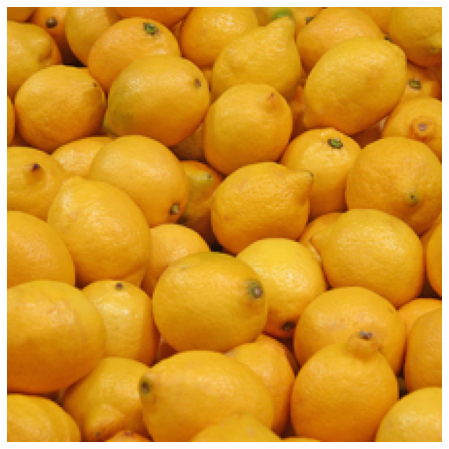

In [5]:
image = Image.open('lemon.jpeg')
tensor = preprocessing_no_normalize(image)

plt.figure(figsize=(8, 8))
plt.imshow(tensor.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

$\texttt{Pytorch}$ prend en entrée des données dont la première dimension représente celle du batch. S'il n'y a qu'une donnée alors cette première dimension doit toujours exister et vaut $1$.

In [6]:
batch = normalize(tensor)[None, :, :, :] # we create a batch

print('[batch size, channels, width, height]:', batch.size())

[batch size, channels, width, height]: torch.Size([1, 3, 224, 224])


In [12]:
prediction = resnet(batch)

In [13]:
# dim=1 indique qu'on prédit image par image 
# rappelez-vous que dim=0 correspond à la dimension du batch
true_index = prediction.max(dim=1)[1].item()
probability = softmax(prediction, dim=1).max(dim=1)[0][0].item()
true_label = classes_to_labels[true_index]

In [14]:
print(true_label, ':', probability)

lemon : 0.9656189680099487


On observe que notre modèle prédit le bon label avec une très bonne probabilité !

## IV. Une première attaque

### Quelques rappels d'optimisation

Revenons à l'apprentissage de notre réseau de neurones. Notre objectif est de trouver une solution à la minimisation suivante : 

$$\theta^\star=\text{argmin}_{\theta\in\mathbb{R}^p}\frac{1}{n}\sum_i \ell(h_\theta(x_i), y_i)=\text{argmin}_{\theta\in\mathbb{R}^p}\mathcal{L}(h_\theta, S_n).$$

Pour cela, nous exploitons le fait que $\mathcal{L}(h_\theta, S_n)$ est différentiable presque partout en tant que fonction de $\theta$ et cela afin d'utiliser l'algorithme de descente de gradient. Ce dernier réalise des pas successifs afin de se rapprocher toujours plus du minimum de notre fonction (ou du moins d'un minimum local). Chacun des pas se construit de la manière suivante :

$$\theta^{(t+1)}=\theta^{(t)}-\eta \nabla_\theta\mathcal{L}(h_{\theta^{(t)}}, S_n)$$

La valeur du gradient $\nabla_\theta\mathcal{L}(h_{\theta^{(t)}}, S_n)$ est elle obtenue au travers de l'algorithme de <em>backpropagration</em>. Le paramètre $\eta>0$ est ce qu'on appelle le pas d'apprentissage ou <em>learning rate</em> et permet de controler la stabilité de l'optimisation mais a aussi un effet de régularisation.

### Construction d'une attaque adversaire

L'idée d'une attaque adversaire est de s'appuyer sur le même raisonnement mais dans l'espace des données $\mathbb{R}^d$. Soit une donnée et son label $(x, y)$. Notre objectif est ainsi de trouver une perturbation $\delta\in\mathbb{R}^d$ telle que la nouvelle donnée $x+\delta$ ne soit plus associée au label $y$. Rappelons que notre loss $\ell$ est une mesure des performances de notre réseau de neurones pour la donnée $(x, y)$. Ainsi, $\ell(h_\theta(x), y)$ est d'autant plus faible que notre modèle est bon et d'autant plus forte que notre modèle est mauvais. Nous allons omettre l'indice $\theta$ de notre modèle puisqu'on le considère maintenant comme une constante.

L'objectif d'une attaque adversaire est donc de trouver un bruit $\delta\in\mathbb{R}^d$ de telle manière à ce que $\ell(h_\theta(x+\delta), y)$ ait la plus grande valeur possible. Ainsi, on peut reformuler l'attaque adversaire via le problème de minimisation suivant :

$$\delta^\star=\text{argmin}_{\delta\in\mathbb{R}^d}-\ell(h_{\theta}(x+\delta), y).$$

Observez qu'on minimise bien l'opposé de notre <em>loss</em> puisqu'on est en réalité intéressé par une maximisation.

**<span style='color:blue'> Exercice</span>** 
Complétez l'algorithme suivant permettant de construire notre attaque adversaire.



 ----

In [10]:
# we initialize delta with 0
delta = zeros_like(tensor, requires_grad=True)

In [ ]:

# we construct our optimizer and loss
optimizer = optim.SGD([delta], lr=2e-1)
criterion = CrossEntropyLoss()

# we construct the target
target = LongTensor([true_index])

for iteration in range(60):
    ############### COMPLETE HERE ###############
    ...
    ...
    ...

    if iteration % 5 == 0:
        print('\r[%d] loss: %.3f' % (iteration, loss.item()), end="")
    
    ...
    #############################################


In [ ]:
batch = normalize(tensor + delta)[None, :, :, :]
logit = resnet(batch)

print('\rTrue class probability:', softmax(logit, dim=1)[0, true_index].item())

new_index = logit.max(dim=1)[1].item()
new_label = classes_to_labels[new_index]

print('New class:', new_label)


Excellent, nous avons réussi à transformer notre image $x$ via un bruit $\delta$ de manière à piéger notre modèle ! On observe de plus que la probabilité de la bonne classe est maintenant ridiculement faible et se retrouve très probablement parmi les classes les moins probables. Observons le résultat de notre attaque adversaire.

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.title('Notre image transformée $x+\delta$')
plt.imshow((tensor + delta).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(132)
plt.title('Le bruit $\delta$')
plt.imshow((delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(133)
plt.title('Le bruit $\delta$ amplifié')
plt.imshow((50*delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()


Oups ! Notre image ne ressemble plus à rien. Le bruit ajouté est clairement visible. On pourrait même, si nous ne savions pas qu'il s'agit de citrons, douter et penser qu'il s'agit réellement d'oranges...

## V. Un deuxième essai

La stratégie va être de contraindre les déformations à rester à l'intérieur d'une boule dont nous pourrons contrôler le rayon et le fixer à de petites valeurs :

$$\mathcal{B}_\epsilon=\{x\in\mathbb{R}^d:\ \lVert x\rVert\leq \epsilon\}$$

Considérons le cas simple de la norme $\ell_\infty$ :

$$\lVert x\rVert_\infty=\text{max}_i|x_i|.$$

Contraindre un vecteur à rester au sein d'une boule de rayon $\epsilon$ revient pour la norme $\ell_\infty$ à tronquer chaque coordonnée de manière à ce que sa valeur absolue ne dépasse pas $\epsilon$.

**<span style='color:blue'> Exercice</span>** 
Complétez l'algorithme suivant permettant de construire notre attaque adversaire en contraignant le vecteur $\delta$ à rester dans une boule de rayon $\epsilon$. Utilisez la méthode $\texttt{delta.data.clamp}\_\texttt{(min, max)}$ qui permet de tronquer la valeur.



 ----

In [14]:
# we initialize delta with 0
delta = zeros_like(tensor, requires_grad=True)

In [ ]:
epsilon = 2./255

# we construct our optimizer and loss
optimizer = optim.SGD([delta], lr=2e-1)
criterion = CrossEntropyLoss()

# we construct the target
target = LongTensor([true_index])

for iteration in range(60):
    ############### COMPLETE HERE ###############
    # we construct the batch
    ...
    ...

    if iteration % 5 == 0:
        print('\r[%d] loss: %.3f' % (iteration, loss.item()), end="")
    
    ...
    ...
    #############################################


In [ ]:
batch = normalize(tensor + delta)[None, :, :, :]
logit = resnet(batch)

print('\rTrue class probability:', softmax(logit, dim=1)[0, true_index].item())

new_index = logit.max(dim=1)[1].item()
new_label = classes_to_labels[new_index]

print('New class:', new_label)


Affichons maintenant l'image ainsi obtenue et le bruit qui lui est associé :

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.title('Notre image transformée $x+\delta$')
plt.imshow((tensor + delta).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(132)
plt.title('Le bruit $\delta$')
plt.imshow((delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(133)
plt.title('Le bruit $\delta$ amplifié')
plt.imshow((50*delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()


C'est beaucoup mieux ! Cependant, ce n'est pas en transformant des citrons en oranges que nous arriverons à prendre le contrôle de l'univers ! Ce que nous souhaiterions, c'est tromper le réseau de neurones avec une classe qui n'a RIEN À VOIR !!

Avant d'aller plus loin, il convient de comprendre un peu mieux pourquoi le réseau de neurones a choisi la classe orange à la place de citron. En minimisant l'opposé de l'entropie croisée afin de trouver notre bruit $\delta$ nous avons en réalité principalement réduit l'amplitude des logits (i.e. le vecteur de score associé à chaque classe) pour la classe citron... Celle-ci en perdant de l'importance a laissé la place à la deuxième classe la plus probable pour cette image : les oranges.

## VI. Une attaque un petit peu plus ciblée ?

Ce que nous voulons ici, c'est minimiser l'importance d'une classe $A$ tout en augmentant l'importance d'une classe $B$. Le problème qui nous intéresse est donc :

$$\delta^\star=\text{argmin}_{\delta\in\mathcal{B}_\epsilon}-\ell(h_{\theta}(x+\delta), y)+\ell(h_{\theta}(x+\delta), y_{\text{target}}),$$

où $y_{\text{target}}$ est la classe que nous aimerions voir prédite. Choisissons maintenant la classe que nous visons :

In [18]:
target_index = 589
print('Selected target:', classes_to_labels[target_index])

Selected target: hand blower, blow dryer, blow drier, hair dryer, hair drier


**<span style='color:blue'> Exercice</span>** 
Complétez l'algorithme suivant permettant de construire notre attaque adversaire en contraignant le vecteur $\delta$ à rester dans une boule de rayon $\epsilon$ et en ciblant une classe objectif.



 ----

In [19]:
# we initialize delta with 0
delta = zeros_like(tensor, requires_grad=True)

In [ ]:
epsilon = 2./255

# we initialize delta with 0
delta = zeros_like(tensor, requires_grad=True)

# we construct our optimizer and loss
optimizer = optim.SGD([delta], lr=5e-3)
criterion = CrossEntropyLoss()

# we construct the targets
true_target = LongTensor([true_index])
target_target = LongTensor([target_index])

for iteration in range(100):
    ############### COMPLETE HERE ###############
    ...
    ...
    ...

    if iteration % 5 == 0:
        print('\r[%d] loss: %.3f' % (iteration, loss.item()), end="")
    
    ...
    ...
    #############################################


In [ ]:
batch = normalize(tensor + delta)[None, :, :, :]
logit = resnet(batch)

print('\rTrue class probability:', softmax(logit, dim=1)[0, true_index].item())

new_index = logit.max(dim=1)[1].item()
new_label = classes_to_labels[new_index]

print('New class:', new_label)


Victoire ! Observons maintenant l'image bruitée ainsi que le bruit associé.

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.title('Notre image transformée $x+\delta$')
plt.imshow((tensor + delta).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(132)
plt.title('Le bruit $\delta$')
plt.imshow((delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(133)
plt.title('Le bruit $\delta$ amplifié')
plt.imshow((50*delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()


Nous avons ainsi réussi à choisir notre classe objectif et à perturber notre réseau de neurones avec un bruit invisible à l'oeil nu.

## VII. La méthode "fast-sign"

Nous avons pu constater dans l'exemple précédent que la construction d'un exemple adversaire demandait de minimiser une fonction de coût (i.e. l'opposé de ce qu'on souhaiterait minimiser en temps normal). Cette minimisation prend un certain temps pour une unique image.

Il existe une méthode alternative, moins performante en terme d'attaque mais plus efficace computationnellement. Il s'agit de la méthode "fast-sign". Rappelons que l'objectif d'une attaque adversaire est de construire le bruit suivant : 

$$\delta^\star=\text{argmin}_{\delta\in\mathcal{B}_\epsilon}-\ell(h_{\theta}(x+\delta), y).$$

L'intuition derrière la méthode "fast-sign" est de supposer que la direction du gradient au cours de la minimisation ne changera pas très significativement. Ainsi, au lieu de réaliser plusieurs petits pas successifs, nous pouvons réaliser un grand pas dans la direction du gradient au point de départ. Notons que nous souhaitons que notre vecteur de bruit reste dans une boule en norme infini $\ell_\infty$. Cela revient à dire que pour chaque coordonnée positive de notre gradient nous voulons que $\delta_j=-\epsilon$ et pour chaque coordonnée négative, nous voulons $\delta_j=\epsilon$ (nous voulons aller le plus loin possible). Notre bruit devient donc :

$$\hat{\delta}=-\epsilon\cdot\text{sign}(\nabla_\delta\ell(h_{\theta}(x+\delta), y)).$$

**<span style='color:blue'> Exercice</span>** 
À vous d'implémenter la méthode *fast-sign* dans le cas d'une attaque non ciblée.



 ----

In [23]:
# we initialize delta with 0
delta = zeros_like(tensor, requires_grad=True)

In [ ]:
epsilon = 2./255

# we construct our loss
criterion = CrossEntropyLoss()

# we construct the target
target = LongTensor([true_index])

batch = normalize(tensor + delta)[None, :, :, :]

pred = resnet(batch)

############### COMPLETE HERE ###############
loss = ...
...

delta = ...
#############################################

batch = normalize(tensor + delta)[None, :, :, :]
pred = resnet(batch)

print('\rTrue class probability:', softmax(pred, dim=1)[0, true_index].item())

new_index = pred.max(dim=1)[1].item()
new_label = classes_to_labels[new_index]

print('New class:', new_label)


La performance de l'attaque est grandement réduite, mais fonctionne ! Visualisons le résultat :

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.title('Notre image transformée $x+\delta$')
plt.imshow((tensor + delta).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(132)
plt.title('Le bruit $\delta$')
plt.imshow((delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(133)
plt.title('Le bruit $\delta$ amplifié')
plt.imshow((50*delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()


**<span style='color:blue'> Exercice</span>** 
À vous d'implémenter la méthode *fast-sign* dans le cas d'une attaque ciblée.



 ----

In [26]:
# we initialize delta with 0
delta = zeros_like(tensor, requires_grad=True)

In [ ]:
epsilon = 50./255

target_index = 589
print('Selected target:', classes_to_labels[target_index])

# we construct our loss
criterion = CrossEntropyLoss()

# we construct the target
true_target = LongTensor([true_index])
target_target = LongTensor([target_index])

batch = normalize(tensor + delta)[None, :, :, :]

pred = resnet(batch)

############### COMPLETE HERE ###############
...
...
...
#############################################



batch = normalize(tensor + delta)[None, :, :, :]
pred = resnet(batch)

print('\rTrue class probability:', softmax(pred, dim=1)[0, true_index].item())

new_index = pred.max(dim=1)[1].item()
new_label = classes_to_labels[new_index]

print('New class:', new_label)


Il est probable que cette attaque ait échoué. En effet, nous avons déjà pu observer que dans le cas non ciblé, notre attaque avait eu beaucoup moins d'effet. L'effet sur les logits de la bonne classe est encore plus réduit lorsque l'attaque devient ciblée. Pour que l'attaque fonctionne, nous devons considérer un déplacement plus significatif qui risque d'être visible à l'écran...

Testez plusieurs valeurs de $\epsilon$ et observez le résultat à la fois en termes de prédiction que visuellement avec le code ci-dessous.

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.title('Notre image transformée $x+\delta$')
plt.imshow((tensor + delta).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(132)
plt.title('Le bruit $\delta$')
plt.imshow((delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(133)
plt.title('Le bruit $\delta$ amplifié')
plt.imshow((50*delta + 0.5).detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()


## VIII. Devenir robuste aux attaques adversaires

### Introduction
Comme indiqué plus haut, l'objectif de notre apprentissage est de trouver la solution :

$$\theta^\star=\text{argmin}_{\theta\in\mathbb{R}^p}\frac{1}{n}\sum_i \ell(h_\theta(x_i), y_i)=\text{argmin}_{\theta\in\mathbb{R}^p}\mathcal{L}(h_\theta, S_n).$$

C'est la paramétrisation qui fait le moins d'erreur (au sens de la loss $\ell$) sur notre jeu de données d'apprentissage. Si le choix de notre classe de fonctions et de nos hyperparamètres est bon, alors cette même paramétrisation fonctionnera également sur des données que nous n'avons pas encore vu. Cependant, cette dernière peut être très sensible aux attaques adversaires comme nous avons pu le voir ci-dessus. Une solution consiste à ne pas minimiser notre loss sur le jeu d'apprentissage, mais notre loss dans le pire des cas :

$$\theta^\star=\text{argmin}_{\theta\in\mathbb{R}^p}\frac{1}{n}\sum_i \text{max}_{\delta\in\mathcal{B}_\epsilon}\ell(h_\theta(x_i+\delta), y_i).$$

Rappelons nous que l'algorithme de descente de gradient a besoin de ce dernier. Il nous faut donc calculer le gradient du maximum. Il se trouve que la solution est assez simple et revient à calculer le gradient au point $\delta^\star$, solution du maximum :

$$\nabla_\theta \text{max}_{\delta\in\mathcal{B}_\epsilon}\ell(h_\theta(x_i+\delta), y_i)=\nabla_\theta \ell(h_\theta(x_i+\delta^\star), y_i).$$

### Construction du jeu de données
Nous utiliserons ici le jeu de données MNIST restreint aux chiffres 0 et 1.

In [7]:
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

/Users/maximilienservajean/Documents/PycharmProjects/lmipr/Travaux pratiques/Machine Learning/Book/7_regularization


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [ ]:
train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 512, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 512, shuffle=False)

Visualisons la tête de ces données.

In [ ]:
iterator = iter(train_loader)
images, labels = next(iterator)

plt.figure(figsize=(12,12))
for j in range(16):
    plt.subplot(4, 4, j+1)
    plt.title(str(labels[j].numpy()))
    plt.imshow(torch.squeeze(images[j].detach()).numpy())
    plt.axis('off')
plt.show()

### Un cas simple : le modèle linéaire (Rappels)

La méthode "fast-sign" permet d'obtenir efficacement un adversaire mais le résultat n'est qu'approximatif. Le cas du modèle linéaire est intéressant car il est possible de trouver analytiquement les solutions de la maximisation (l'adversaire). Comme nous l'avons vu, un modèle linéaire cherche à séparer les classes par un ou plusieurs (multi-classes) hyperplans. Supposons que nous soyons dans $\mathbb{R}^d$, un hyper-plan est décrit par un vecteur $\omega\in\mathbb{R}^d$ et un scalaire $b\in\mathbb{R}$. Le vecteur $\omega$ donne l'orientation de l'hyperplan et $b$ sa "distance" à "l'origine". Ainsi, un hyperplan est représenté par l'ensemble des points suivants :

$$\{x\in\mathbb{R}^d:\ \langle \omega, x\rangle+b=0\}.$$

Au-delà des points de l'hyperplan, la quantité $\langle \omega, x,\rangle+b$ est positive si on est d'un côté de l'hyperplan et négative de l'autre. Considérons le cas binaire et notons nos classes $\mathcal{Y}=\{-1,+1\}$. On souhaiterait que le côté négatif de l'hyperplan soit associé aux données dont le label est -1 et de la même manière que le côté positif soit associé aux données dont le label est +1.

Soit la fonction $\text{sign}(z)$ qui retourne $+1$ si $z>0$ et $-1$ si $z\leq 0$. Le classifieur associé à notre hyperplan se construit donc de la manière suivante : 

$$h_\theta(x)=\text{sign}(\langle \omega, x\rangle + b),\ \theta=\{\omega\in\mathbb{R}^d,b\in\mathbb{R}\}.$$

Par simplicité de notation nous ommettrons à partir de maintenant le biais $b$. Notons $g(x)=\langle \omega, x\rangle$. Il s'agit d'une fonction qui donne le score de classification. On remarque que la fonction $g$ prédit le bon label si $g(x)$ a le même signe que $y$. Dit autrement, nos prédictions sont correctes si $g(x)y>0$.

Intuitivement, nous aimerions minimiser la loss 0/1 :

$$\ell_{0/1}(z)=1\{z\leq 0\}.$$

Cette loss retourne $1$ si $z$ est négatif et $0$ sinon. Appliqué à notre modèle, cela donnée $\ell(g(x)y)$ qui vaut $1$ si $g(x)$ n'a pas le même signe que $y$. C'est exactement ce qu'on veut. Cependant, cette loss n'est pas différentiable en $0$ et son gradient vaut $0$ partout ailleurs. Cela nous complique la tâche lorsqu'on cherche à optimiser notre modèle. Utilisons donc une loss possédant de meilleures propriétés mathématiques ainsi que certaines garanties pour la classification. Il s'agit de la fonction de perte logistique :

$$\ell(z)=\text{log}(1+e^{-z}).$$

On remarque que si $z$ est très grand ($g$ et $y$ sont de même signe et le score prédit est grand) alors la fonction est très proche de $0$. Si $z$ est très petit ($g$ et $y$ sont de signe différent et le score prédit est grand) alors la fonction diverge vers $+\infty$. Il s'agit en réalité exactement de l'entropie croisée composée avec la sigmoid que nous avons déjà vu !

Finalement, le problème à résoudre dans le cadre d'un classifieur linéaire est le suivant :

$$\theta^\star=\text{argmin}_{\theta=\omega\in\mathbb{R}^d}\frac{1}{n}\sum_i \ell(y\langle \omega, x\rangle).$$
 

### Construction du modèle

In [ ]:
class LinearClassifier(Module):
    def __init__(self, dim_input=784):
        super(LinearClassifier, self).__init__()
        self.weights = Linear(dim_input, 1)
        self.dim_input = dim_input
        
    def forward(self, x):
        # we flatten the image into a vector
        x = x.view(x.size()[0], self.dim_input)
        # we apply our linear model
        return self.weights(x)

### Construction de la loss

La logistic loss n'est rien d'autre que la sigmoid composée avec l'entropie croisée.

In [ ]:
class LogisticLoss(Module):
    def __init__(self):
        super(LogisticLoss, self).__init__()
        
    def forward(self, y_hat, y):
        # we flatten the image into a vector
        y_hat = torch.squeeze(y_hat)
        batch_size = y_hat.size()[0]
        y = 2*y-1  # on met les labels entre -1 (anciennement 0) et 1
        z = y*y_hat
        return torch.sum(torch.log(1+torch.exp(-z))) / batch_size

### Entraînement

Notez qu'il s'agit encore et toujours ici de l'entraînement classique où nous ne tenons pas compte des attaques adversaires.

In [ ]:
# TODO Décommenter les prints de loss, etc.
def train_and_plot(lr=0.005, epochs=50, logs=10, criterion=LogisticLoss()):
    model = LinearClassifier()
    # model.cuda()
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
    
    loss_history = []
    running_loss = 0.0
    for e in range(epochs):
        for idx, data in enumerate(train_loader):
            inputs, labels = data
            # labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            if idx % logs == logs - 1:  # print every 2000 mini-batches
                print('\r[%d, %5d] loss: %.3f' % (e + 1, idx + 1, running_loss / logs), end="")
                loss_history.append(running_loss / logs)
                running_loss = 0.0

            loss.backward() # on calcule le gradient
            optimizer.step() # on fait un pas d'optimisation
    print('\r************* Training done! *************')
    plt.figure(figsize=(14, 8))
    plt.plot(loss_history)
    plt.title('Loss')
    plt.show()
    return model

In [ ]:
model = train_and_plot(lr=0.001, epochs=60, logs=1)

### Test des performances

In [ ]:
def test(model):
    model.eval()  # on passe le modele en mode evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            #images = images.cuda()
            #labels = labels.cuda()
            outputs = model(images)
            predicted = torch.squeeze((outputs > 0).float())
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    model.train()  # on remet le modele en mode apprentissage
    print('Accuracy du modele sur le jeu de test: %d %%' % (100 * correct / total))

In [ ]:
test(model)

### Construction d'une attaque adversaire dans le cas du modèle linéaire


En reprenant le problème de l'apprentissage robuste aux attaques adversaires tel que défini ci-dessus, notre loss n'est plus directement $\ell$. En effet, comme indiqué, nous devons non pas évaluer $\ell$ en $x$ mais dans un voisinage de $x$ tel que le score de notre modèle y est le plus mauvais possible. La *loss* dans le pire des cas est décrite par l'équation suivante :

$$\text{max}_{\delta\in\mathcal{B}_\epsilon}\ell(y\langle\omega, x+\delta\rangle)=\text{max}_{\delta\in\mathcal{B}_\epsilon}\text{log}(1+e^{-y\langle\omega, x+\delta\rangle}).$$

Avant d'aller plus loin, observons notre fonction de perte logistique.

In [ ]:
z=np.linspace(-5, 5, 101)
y=np.log(1+np.exp(-z))

plt.figure(figsize=(14, 10))
plt.plot(z, y)
plt.title('La fonction de perte logistique')
plt.show()

Celle-ci semble monotone et décroissante (et convexe). Pour nous en convaincre, calculons la dérivée :

$$\ell^\prime(z)=-\frac{1}{e^z+1}<0,$$

qui est bien toujours négative confirmant à la fois la monotonie et la décroissance. Pour le fun, constatons que notre fonction est bien également convexe :

$$\ell^{\prime\prime}(z)=\frac{e^z}{(e^z+1)^2}>0.$$

La fonction de perte logistique est donc même strictement convexe.

---

En constatant ainsi que la fonction de perte logistique est monotone ET décroissante et en exploitant la linéarité du produit scalaire, on obtient donc :

$$\text{max}_{\delta\in\mathcal{B}_\epsilon}\ell(y\langle\omega, x+\delta\rangle)=\ell(\text{min}y\langle\omega, x+\delta\rangle)=\ell(y\langle\omega, x\rangle+\text{min}y\langle \omega, \delta\rangle).$$

Il nous reste donc à chercher la solution du problème de minimisation $\text{min}_{\delta\in\mathcal{B}_\epsilon}y\langle \omega, \delta\rangle$
qui, heureusement pour nous, est convexe avec un domaine de définition compact. Il y a donc un minimum local qui est le minimum global. La norme $\ell_\infty$ nous permet de considérer chaque dimension séparément (le problème est séparable). Nous voulons donc calculer :

$$\text{min}_{|\delta_j|\leq \epsilon}y\langle \omega_j, \delta_j\rangle.$$

Si $\omega_j=0$, toutes les solutions se valent. Si $\omega_j\neq 0$ et $y=-1$, alors le minimum est atteint lorsque $\delta_j=\epsilon\cdot\text{sign}(\omega_j)$. Enfin, si $y=1$, alors le minimum est atteint lorsque $\delta_j=-\epsilon\cdot\text{sign}(\omega_j)$. De manière générale, nous avons :

$$\delta^\star=-y \epsilon\cdot\text{sign}(\omega)$$

Nous avons ainsi : 

$$\text{min}_{\delta\in\mathcal{B}_\epsilon}y\langle \omega, \delta\rangle=y\langle\omega, -y \epsilon\cdot\text{sign}(\omega)\rangle=-y^2\epsilon\langle \omega, \text{sign}(\omega)\rangle=-\epsilon\lVert\omega\rVert_1.$$

Un apprentissage robuste aux attaques adversaires minimise donc la loss :

$$\text{max}_{\delta\in\mathcal{B}_\epsilon}\text{log}(1+e^{-y\langle\omega, x\rangle+\epsilon\lVert\omega\rVert_1})=\ell(y\langle\omega, x\rangle-\epsilon\lVert\omega\rVert_1)$$

On retombe quasiment sur un problème d'optimisation avec une pénalité $\ell_1$. On cherche le vecteur $\omega$ qui maximise les bonnes prédictions mais qui en même temps possède une norme $\ell_1$ faible.

**<span style='color:blue'> Exercice</span>** 
En vous appuyant sur les "résultats théoriques" précédent, proposez un code permettant de générer un bruit adversaire.



 ----

In [ ]:
def generate_adversarial_noise(image_and_label, model, epsilon=0.5):
    imagesize = (1, 28, 28)
    image, label = image_and_label
    label = -1 if label==0 else label
    ############### COMPLETE HERE ###############
    noise = ...
    #############################################
    
    return noise


In [ ]:
def plot_images_and_noise(image, noise):
    plt.figure(figsize=(18,18))
    plt.subplot(131)
    plt.title('Notre image $x$')
    plt.imshow(torch.squeeze(image.detach()).numpy())
    plt.axis('off')
    plt.subplot(132)
    plt.title('Notre image transformée $x + \delta^\star$')
    plt.imshow(torch.squeeze((image+noise).detach()).numpy())
    plt.axis('off')
    plt.subplot(133)
    plt.title('Notre bruit $\delta^\star$')
    plt.imshow(torch.squeeze(noise.detach()))
    plt.axis('off')
    plt.show()


In [ ]:
iterator = iter(train_loader)

images, labels = next(iterator)
noise = generate_adversarial_noise((images[0], labels[0]), model)

plot_images_and_noise(images[0], noise)

prediction = 0 if model(images[0])[0, 0] < 0 else 1
print('Prédiction:', prediction)
prediction = 0 if model(images[0]+noise)[0, 0] < 0 else 1
print('Prédiction avec du bruit:', prediction)


### Apprentissage robuste aux attaques adversaires

Un apprentissage robuste aux exemples adversaires cherche tout simplement à minimiser le pire des scénarios :

$$\omega^\star=\text{argmin}_{\omega\in\mathbb{R}^d}\frac{1}{n}\sum_i\text{max}_{\delta\in\mathcal{B}_\epsilon}\ell(y_i\langle\omega, x_i +\delta\rangle)=\text{argmin}_{\omega\in\mathbb{R}^d}\frac{1}{n}\sum_i\ell(y_i\langle\omega, x_i\rangle-\epsilon\lVert\omega\rVert_1).$$

**<span style='color:blue'> Exercice</span>** 
En vous appuyant sur les "résultats théoriques" précédent, proposez un code permettant de construire une loss robuste aux attaques adversaires.



 ----

In [ ]:
class RobustLogisticLoss(Module):
    def __init__(self, weights, epsilon=0.5):
        super(RobustLogisticLoss, self).__init__()
        self.epsilon = epsilon
        self.weights = weights
        
    def forward(self, y_hat, y):
        # we flatten the image into a vector
        y_hat = torch.squeeze(y_hat)
        batch_size = y_hat.size()[0]
        y[y == 0] = -1
        ############### COMPLETE HERE ###############
        z = ......
        #############################################
        
        return torch.sum(torch.log(1+torch.exp(-z))) / batch_size
    
model = train_and_plot(lr=0.001, epochs=60, logs=1, criterion=RobustLogisticLoss(model.weights.weight))


In [ ]:

iterator = iter(train_loader)

images, labels = next(iterator)
noise = generate_adversarial_noise((images[0], labels[0]), model)

plot_images_and_noise(images[0], noise)

prediction = 0 if model(images[0])[0, 0] < 0 else 1

print('Prédiction:', prediction)
prediction = 0 if model(images[0]+noise)[0, 0] < 0 else 1
print('Prédiction avec du bruit:', prediction)


Il se trouve que les modèles linéaires sont déjà beaucoup plus robustes aux attaques adversaires que les réseaux de neurones. Malheureusement, les choses sont plus compliquées pour ces dernières puisque il n'y a déjà pas de solution analytique...

## En résumé

*  Nous avons vu comment formaliser la notion d'attaque adversaire via un problème d'optimisation sous contrainte :

$$\delta^\star=\text{argmin}_{\delta\in\mathcal{B}_\epsilon}-\ell(h_{\theta}(x+\delta), y),$$

*  Nous avons vu une manière de cibler l'attaque afin de "forcer" notre modèle à prédire une classe particulière :

$$\delta^\star=\text{argmin}_{\delta\in\mathcal{B}_\epsilon}-\ell(h_{\theta}(x+\delta), y)+\ell(h_{\theta}(x+\delta), y_{\text{target}}),$$

*  Nous avons contourné le processus d'optimisation via une heuristique, la méthode *fast-sign* :

$$\hat{\delta}=-\epsilon\cdot\text{sign}(\nabla_\delta\ell(h_{\theta}(x+\delta), y)),$$

*  Nous avons également formalisé le problème d'apprentissage robuste aux attaques : 

$$\theta^\star=\text{argmin}_{\theta\in\mathbb{R}^p}\frac{1}{n}\sum_i \text{max}_{\delta\in\mathcal{B}_\epsilon}\ell(h_\theta(x_i+\delta), y_i),$$

*  Et avons résolu la maximisation dans le cadre d'un classifieur linéaire :

$$\omega^\star=\text{argmin}_{\omega\in\mathbb{R}^d}\frac{1}{n}\sum_i\ell(y_i\langle\omega, x_i\rangle-\epsilon\lVert\omega\rVert_1).$$